# Graphs for Machine Learning - TP1

## Théo Di Piazza - theo.dipiazza@gmail.com

# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -r /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [3]:
! cp /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/generate_data.py /content/generate_data.py
! cp /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/utils.py /content/utils.py
! cp /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/spectral_clustering.py /content/spectral_clustering.py
! cp /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/image_segmentation.py /content/image_segmentation.py
! cp /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/build_similarity_graph.py /content/build_similarity_graph.py
! cp -av /content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/data /content/data

'/content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/data' -> '/content/data'
'/content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/data/fruit_salad.bmp' -> '/content/data/fruit_salad.bmp'
'/content/gdrive/MyDrive/ENS_MVA/S2/graphsML/TP1/data/four_elements.bmp' -> '/content/data/four_elements.bmp'


In [4]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend, plot_edges_and_points
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import math

In [5]:
!git clone https://github.com/TheoDpPro/mva_graph_ml.git

Cloning into 'mva_graph_ml'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 3.81 MiB | 4.76 MiB/s, done.


## Generating the data

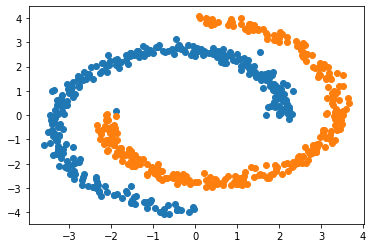

In [ ]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [6]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    # First step : build similarities
    similarities = np.zeros((n, n)) # initialize array
    # Iterate over edge (i, j)
    for i in range(len(X)):
      X_i = X[i] # get vertice i
      for j in range(len(X)):
        X_j = X[j] # get vertice j
        if(i!=j):
          similarities[i, j] = np.exp(-pow(np.linalg.norm(X_i - X_j), 2) / (2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        '''
        # Iterate over edge (i, j)
        for i in range(len(X)):
          for j in range(len(X)):
            if(similarities[i, j] >= eps):
              W[i, j] = similarities[i, j]
        '''
        W = similarities
        W[W < eps] = 0

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        # Implement with undirected graph : OR option : slides 8, course 2.

        # For each node
        for i in range(n):
          # Select similarities for the node i
          X_i_sim = similarities[i, :]
          # Sort neighboors by descending order (to keep more similars)
          k_neighboors = np.argsort(-X_i_sim)[:k]
          # For each closest neighboor
          for j in k_neighboors:
            # Update weight matrix
            W[i, j] = similarities[i, j]
            W[j, i] = similarities[i, j]

    return W


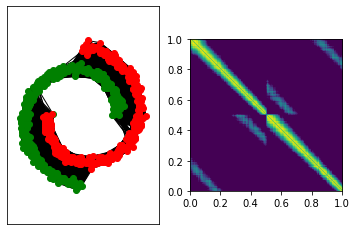

In [ ]:
#@title 
# Plot Graph Matrix from epsilon-graph
W = build_similarity_graph(X, k=0, eps=0.3)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

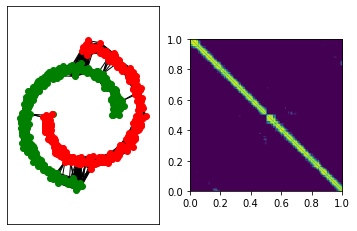

In [ ]:
#@title 
# Plot Graph Matrix from knn-graph
W = build_similarity_graph(X, k=30)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [7]:
import scipy

def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape) # initialize L
    n = W.shape[0] # number of points

    # Initialize and fill matrix D
    D = np.diag(np.sum(W, axis=1))
    
    # select Laplacians : slides 19, course2.
    if(laplacian_normalization=='unn'): # normal
      L = D - W
    elif(laplacian_normalization=='sym'): # symmetric
      L = np.identity(n) - np.sqrt(np.linalg.pinv(D)).dot(W).dot(np.sqrt(np.linalg.pinv(D)))
    elif(laplacian_normalization=='rw'): # random walk
      L = np.identity(n) - np.linalg.pinv(D).dot(W)
    else:
      print("WARNING : laplacian_normalization should be 'unn', 'sym', or 'rym'.")

    return L

## Clustering

In [8]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, method='classic'):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)
    method : str
        Method to use to select number of eigen vectors.
        classic, classic2, gap_max, gap_max2.

    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    # Compute eigenvalues and eigenvectors from L
    E, U = scipy.linalg.eig(L) # eigen values, eigen vectors
    # sort E and re-arrange U in ascending order of eigen values
    idx_E = E.argsort()
    E = E[idx_E].real
    U = U[:, idx_E].real

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    # Extract eigenvectors for clustering
    if(chosen_eig_indices): # if indices to keep chosen as parameter
      U = U[:, chosen_eig_indices] # extract eigenvectors to keep

    else:

      if(method=='classic'):
        threshold_eigenvalue = 1e-4 # threshold to consider an eigenvalue close to 0
        chosen_index_limit = np.sum(E < threshold_eigenvalue) # number of eigen values close to 0

      elif(method=='classic2'):
        threshold_eigenvalue = 1e-4 # threshold on the sum of sum of eigen values
        chosen_index_limit = np.sum(np.cumsum(E) < threshold_eigenvalue)
        print(f'chosen_index_limit : {chosen_index_limit}')

      elif(method=='gap_max'):
        chosen_index_limit = np.argmax(np.diff(E)) + 1 # chose eigenvalues until the biggest gap

      elif(method=='gap_max2'):
        chosen_index_limit = np.argmax(np.diff(E) / np.cumsum(E)[:-1]) + 1 # chose eigenvalues until the biggest "normalized gap"
        
      if(chosen_index_limit < 2): # if only the null eigenvalue is below the threshold
          chosen_index_limit = 2 # force to look at the second smallest eigen value

      U = U[:, 1:chosen_index_limit] # extract eigenvectors to keep

    Y = KMeans(num_classes).fit_predict(U) # cluster with KMEANS

    return Y

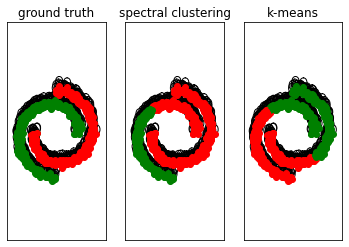

In [ ]:
# Example

num_classes = 2
W = build_similarity_graph(X, k=20)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [9]:
def parameter_sensitivity(parameter_type = 'eps'):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.

    Parameters
    ----------
    parameter_type : str
        parameter to study. eps or k
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'rw'

    """
    Choose candidate parameters
    """

    # initialize values that will be tested for the parameter
    if(parameter_type=='eps'):
      parameter_candidate = np.linspace(0, 1, 20) # the epsilon threshold (if 'eps')
    else:
      parameter_candidate = np.int_(np.linspace(1, 50, 20))  # the number of neighbours for the graph (if 'k')


    plt.figure() # initialize figure


    # iterate over the 3 ways to compute Laplacian
    for laplacian_normalization in ['unn', 'sym', 'rw']:
 
      parameter_performance = [] # array that saves scores

      # iterate over values that will be tried
      for parameter in parameter_candidate:

          # Generate data
          X, Y = two_moons(num_samples, 1, 0.02)
          num_classes = len(np.unique(Y)) # number of classes
          
          parameter_wrap = {parameter_type: parameter}
          
          # comptute W, Laplacian
          W = build_similarity_graph(X, **parameter_wrap) 
          L = build_laplacian(W, laplacian_normalization) 

          # spectral clustering
          Y_rec = spectral_clustering(L, num_classes, method='gap_max') 

          # compute score
          parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

      plt.plot(parameter_candidate, parameter_performance, label=laplacian_normalization)

    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.xlabel(f'{parameter_type}')
    plt.ylabel(f'ARI')
    plt.legend()
    plt.show()

## Image segmentation

In [10]:
def image_segmentation(input_img='four_elements.bmp', num_classes=2, k=2, eps=0.0, laplacian_normalization='unn', chosen_eig_indices=[1]):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    Parameters
    ----------
    input_img : str
          name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    num_classes : int
          number of clusters
    k : int
          number of neighbours
    eps : float
          value for epsilon
    laplacian_normalization : str
          way to compute Laplacian (unn, sym or rw)
    chosen_eig_indices : array
          eigen vectors to select
    """
    # load image, adjust and reshape
    filename = os.path.join('data', input_img)
    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0

    # compute W 
    W = build_similarity_graph(Xr, var=var, k=k, eps=eps)
    # compute Laplacian
    L = build_laplacian(W, laplacian_normalization)
    # make prediction
    Y_rec = spectral_clustering(L, num_classes=num_classes, chosen_eig_indices=chosen_eig_indices, method='classic2')

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X) # display data
    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec) # display predictions

    plt.show()

# Questions

### Question 1.1

What is the purpose of the option parameter in `worst_case_blob`?

<Figure size 640x480 with 0 Axes>

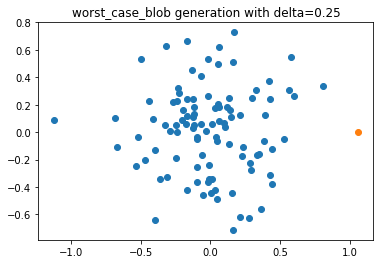

<Figure size 640x480 with 0 Axes>

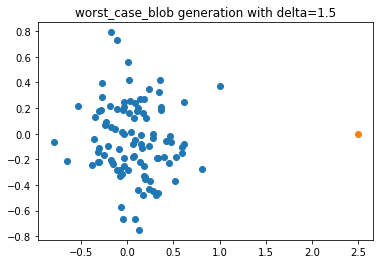

<Figure size 640x480 with 0 Axes>

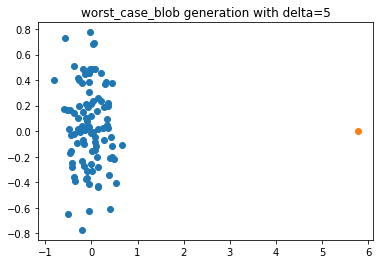

In [ ]:
#@title Answer of Q1.1 : code

# Call worst_case_blob with different values for delta
num_samples = 100 # number of sample to generate
delta_values = [0.25, 1.5, 5] # different values to try for delta parameter

for delta in delta_values:
  plt.figure(figsize=(8, 6), dpi=80)
  X, Y = worst_case_blob(num_samples, delta=delta) # generate data
  Y[-1] = 1 # change label of last observation to change its color plot
  plot_clusters(X, Y)
  plt.title(f'worst_case_blob generation with delta={delta}')
  plt.show() 

####**Answer Q1.1 :**

The function *worst_case_blob* allows to generate a single blob. The last generated element voluntarily with an ordinate equal to 0 and an abscissa equal to **the maximum coordinate of the generated points + delta**. The smaller delta ⟹ the closer the last point is to the remaining samples of the blob, the larger delta ⟹ the further the last point is from the remaining samples of the blob. To summarize, delta allows to generate a last point more or less distant from the samples of the blob.

### Question 1.2 : 
While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

####**Answer Q1.2 - Part 1:**

The objective of this question is to select a value of $\epsilon$ that keeps the graph connected. Then by varying the parameter **delta** to see what happens.

The function `min_span_tree` returns a matrix T such that $T[i,j] = 1$ if the edge $(i, j)$ is in the min spanning tree. According to Wikipedia : "*A minimum spanning tree (MST) or minimum weight spanning tree is a subset of the edges of a connected, edge-weighted undirected graph that connects all the vertices together, without any cycles and with the minimum possible total edge weight*".

Moreover, when building the similarity graph with parameter $\epsilon$, the edge (i, j) is kept if $W(i, j) \geq \epsilon$.

Hence, a way to keep the graph connected is to find a connected graph thanks to `min_span_tree` and choosing a value of $\epsilon$ that keeps all the edges which are in the min spanning tree, **maximizing similarities in our case**. For example, the value chosen for **$\epsilon$ can be the minimum strictly positive value of the edge weights of the min spanning tree**.

In [ ]:
#@title Answer Q1.2 : code

## see what happens for different values of delta

num_samples = 200 # number of samples to generate

# iterate over different values for delta
for delta in [0.1, 0.25, 0.5, 1, 2, 5]:

  print(f'For delta: {delta}')

  X, Y = worst_case_blob(num_samples, delta=delta) # generate data
  W = build_similarity_graph(X, k=0, eps=0) # build similarity graph with eps=0 to keep all edges
  nb_edges_initial = np.sum(W>0) # number of edges in the initial graph
  print(f'Initial number of edges: {nb_edges_initial}')

  # apply strategy
  T_mask = min_span_tree(-W) # min span tree by maximizing similarities
  new_W = np.where(T_mask, W, 0) # Set weight of edges that are not in the min span tree to zero
  eps = np.min(new_W[new_W > 0]) # epsilon is the minimum weight of edges of min span tree
  W = build_similarity_graph(X, k=0, eps=eps) # build similary graph with chosen epsilon
  nb_edges_epsilon = np.sum(W>0) # number of edges that are still in the graph

  print(f'Number of edges with epsilon graph: {nb_edges_epsilon} - {100*nb_edges_epsilon/nb_edges_initial:.2f}% of edges conserved with epsilon graph.\n')

For delta: 0.1
Initial number of edges: 39800
Number of edges with epsilon graph: 15274 - 38.38% of edges conserved with epsilon graph.

For delta: 0.25
Initial number of edges: 39800
Number of edges with epsilon graph: 10074 - 25.31% of edges conserved with epsilon graph.

For delta: 0.5
Initial number of edges: 39800
Number of edges with epsilon graph: 23470 - 58.97% of edges conserved with epsilon graph.

For delta: 1
Initial number of edges: 39800
Number of edges with epsilon graph: 36726 - 92.28% of edges conserved with epsilon graph.

For delta: 2
Initial number of edges: 39800
Number of edges with epsilon graph: 39404 - 99.01% of edges conserved with epsilon graph.

For delta: 5
Initial number of edges: 39800
Number of edges with epsilon graph: 39404 - 99.01% of edges conserved with epsilon graph.



####**Answer Q1.2 - Part 2:**

What it's observed from above results is that : 
- The lower delta is, the more edges are removed (weights equal to 0) after the construction of the epsilon graph. This implies the appearance of many 0's in the similarity matrix and allows for faster computation times.

- The more delta increases (1, 2, 5, and so on...) the less the number of edges are weighted to zero.

To summarize:

- This method seems to be a good idea when the data are compact and the weights all relatively close to each other. 
- Bad idea if some points of the dataset are too far away. The method does not seem to be suitable for data sets with the presence of outliers, for example.

### Question 1.3: 

Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

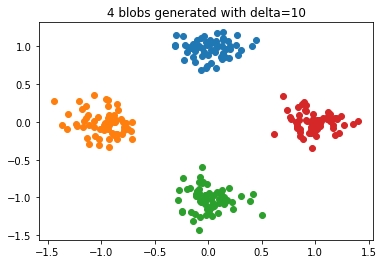

In [ ]:
#@title Answer of Q1.3 : Generate data
num_samples = 250 # number of sample to generate
delta = 10 # different values to try for delta parameter

X, Y = blobs(num_samples, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)
plt.title(f'4 blobs generated with delta={delta}')
plt.show() 

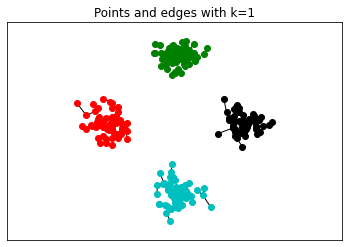

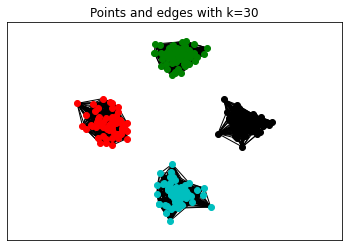

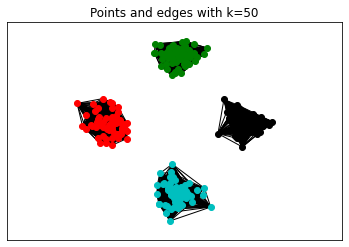

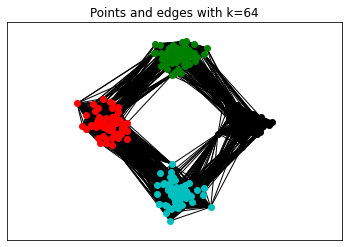

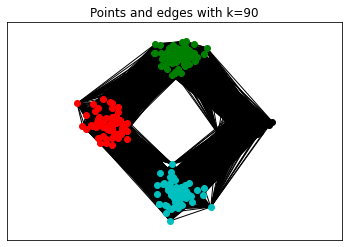

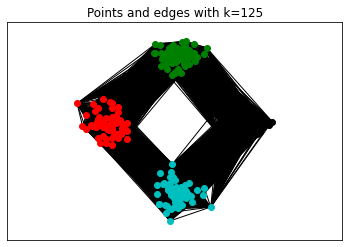

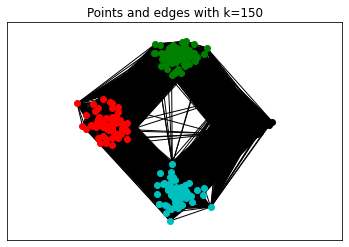

In [ ]:
#@title Answer 1.3 : k-NN

# Plot edge-and-points from k-nn graphs for different values of k
for k in [1, 30, 50, 64, 90, 125, 150]:
  W = build_similarity_graph(X, k=k)
  plot_edges_and_points(X, Y, W, title=f'Points and edges with k={k}')  # shows the graph and the visualization of W
  plt.show()

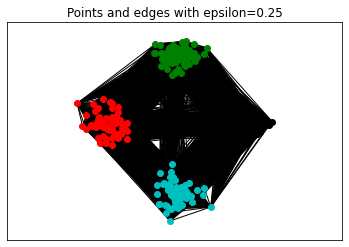

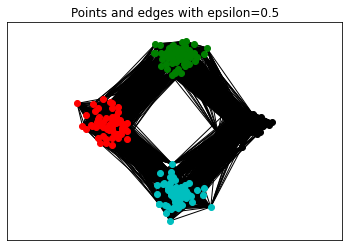

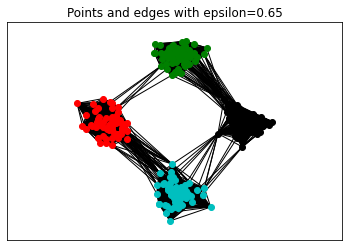

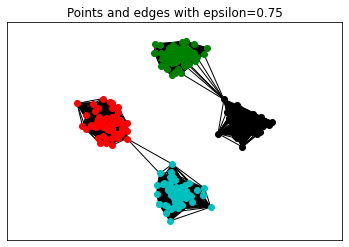

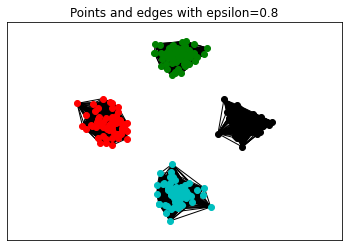

In [ ]:
#@title Answer 1.3 : epsilon

# Plot edge-and-points from epsilon-nn graphs for different values of epsilon
for eps in [0.25, 0.5, 0.65, 0.75, 0.8]:
  W = build_similarity_graph(X, eps=eps)
  plot_edges_and_points(X, Y, W, title=f'Points and edges with epsilon={eps}')  # shows the graph and the visualization of W
  plt.show()

#### **Answer Q1.3:**

First, it is important to build a connected graph in order to find clusters. For example, in the context of spectral clustering, it is beneficial that the graph is connected so that the eigenvectors of the Laplacian matrix are able to capture sufficiently important information to make clusters. If it is not connected, there is a risk that one (or more) cluster will be isolated from the rest of the dataset, and thus have a sub-optimal solution.

> When using k-nn graph, we see that **a large number of neighbors are needed to have a connected graph** : with at least the number of points in each cluster, it is always connected. The more the blobs are far from each other, the more the number of neighbors must be important.

> When using epsilon-graph, **the lower the value of epsilon, the higher the number of connections between different blobs**. 

To summarize k-nn graph is an efficient method because for each point, only the k nearest neighbors are taken into account. However, as we have seen above, there is a risk of obtaining blobs isolated from each other. For the epsilon-graph, we have the guarantee of having a connected graph on epsilon is sufficiently weak. However, the process is very long because all distances between each pair of points must be compared one by one.

### Question 2.1

Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

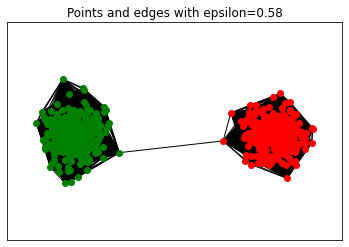

In [ ]:
#@title Answer 2.1 : Generate data

# Build a graph to keep it connected
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, k=0, eps=0)

# apply strategy with min span tree
T_mask = min_span_tree(-W) # since we want with the highest similarities
new_W = np.where(T_mask, W, 0) # Set weight of edges that are not in the min span tree to zero
eps = np.min(new_W[new_W > 0]) # epsilon is the minimum weight of edges of min span tree
W = build_similarity_graph(X, k=0, eps=eps) # build similary graph with chosen epsilon

# Plot the graph
plot_edges_and_points(X, Y, W, title=f'Points and edges with epsilon={eps:.2f}')

> Display eigenvalues of L, first and second eigenvectors of L :



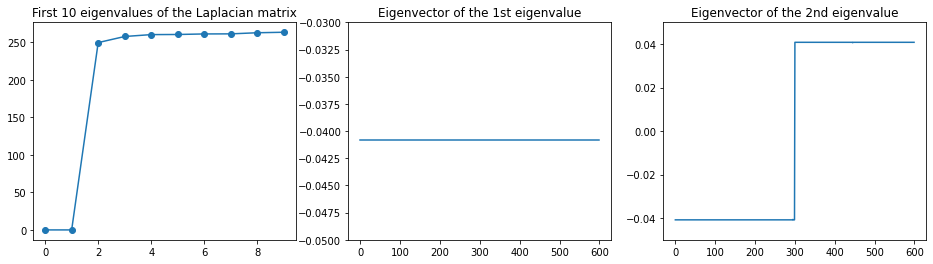


> Results of clustering made directly with eigenvectors of L :



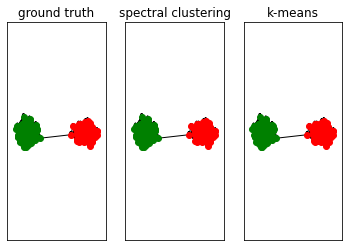

In [ ]:
#@title Answer 1.3 : Cluster with eigenvector of L

# apply spectral clustering with eigenvalues and eigenvectors

L = build_laplacian(W) # compute Laplacian

# Compute eigenvalues and eigenvectors from L
E, U = scipy.linalg.eig(L) # eigen values, eigen vectors
E = E.real # extract real part of complex

# sort E and re-arrange U in ascending order of eigen values
E = E[np.argsort(E)]
U = U[:, np.argsort(E)]

# Plot
print('> Display eigenvalues of L, first and second eigenvectors of L :\n')

# display first 10 eigenvalues
f, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(E[:10], marker = 'o')
axes[0].set_title('First 10 eigenvalues of the Laplacian matrix')

# display eigen vector of the first eigenvalue
axes[1].plot(U[:, 0])
axes[1].set_title('Eigenvector of the 1st eigenvalue')
axes[1].set_ylim([-0.05, -0.03])

# display eigen vector of the second eigenvector
axes[2].plot(U[:, 1])
axes[2].set_title('Eigenvector of the 2nd eigenvalue')
axes[2].set_ylim([-0.05, 0.05])
plt.show()

# Make clustering with thresholds on values of second eigen vector
eigenvector_second = U[:, 1]
Y_rec = 1*(eigenvector_second>0)

# Plot results, comparing to KMeans
print('\n> Results of clustering made directly with eigenvectors of L :\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

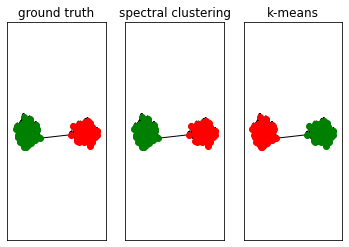

In [ ]:
#@title Answer 2.1 : Cluster with K-means

# Compute Laplacian and make clustering
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=2)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

### Question 2.2

Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

####**Answer 2.2:**

To generate data with 2 components. I propose to compute the matrix W from the k-nn graph method with a number of neighbors voluntarily smaller than the number of points in each component, in order to obtain 2 components. Then, the eigenvalues and eigenvectors of the Laplacian matrix are computed and the eigenvector associated to the first eigenvalue is represented. Contrary to the previous observations, we can see that the eigenvector associated to the null eigenvalue is not constant: it is therefore possible to use its components to cluster the data, using a threshold on the components of the vector. This allows us to obtain the expected results.

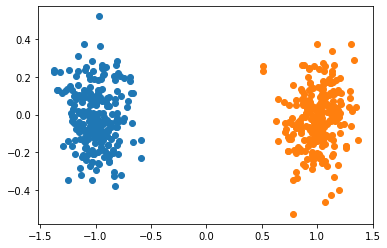

In [ ]:
#@title Answer 2.2 : Generate data
num_samples, eps = 500, 0.90
X, Y = blobs(num_samples, n_blobs=2, blob_var=0.15)
plot_clusters(X, Y)

> Display eigenvalues of L, first and second eigenvectors of L :



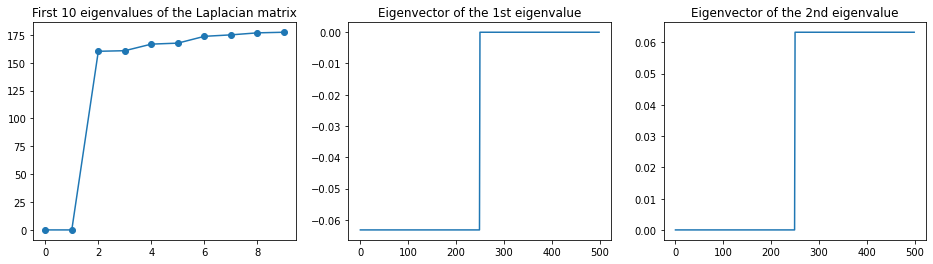


> Results of clustering made directly with eigenvectors of L :



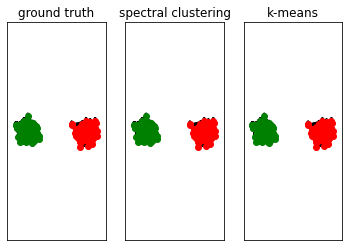

In [ ]:
#@title Answer 2.2 : Cluster

# Compute W then L
W = build_similarity_graph(X, k=200)
L = build_laplacian(W)

# Compute eigenvalues and eigenvectors from L
E, U = scipy.linalg.eig(L) # eigen values, eigen vectors
# sort E and re-arrange U in ascending order of eigen values
idx_E = E.argsort()
E = E[idx_E].real
U = U[:, idx_E].real

# Plot
print('> Display eigenvalues of L, first and second eigenvectors of L :\n')

# display first 10 eigenvalues
f, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].plot(E[:10], marker = 'o')
axes[0].set_title('First 10 eigenvalues of the Laplacian matrix')

# display eigen vector of the first eigenvalue
axes[1].plot(U[:, 0])
axes[1].set_title('Eigenvector of the 1st eigenvalue')

# display eigen vector of the second eigenvector
axes[2].plot(U[:, 1])
axes[2].set_title('Eigenvector of the 2nd eigenvalue')
plt.show()

# Make clustering with thresholds on values of second eigen vector
chosen_eigenvector = U[:, 0]
Y_rec = 1*(chosen_eigenvector>-0.03)

# Plot results, comparing to KMeans
print('\n> Results of clustering made directly with eigenvectors of L :\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

### Question 2.3

In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

**Answer 2.3:**

It is known that 0 is always an eigenvalue of the Laplacian matrix. Thus in order to perform clustering, it is necessary to look at the eigenvectors starting from the first non-zero eigenvalue. As seen in class, the closer the eigenvalue is to 0, the more important the eigenvector is likely to be for the clustering. In particular, we are interested in the eigenvectors associated with the eigenvalues which precede a significant gap between 2 eigenvalues. That's why it is also possible to look for the largest gap between 2 eigenvalues and keep the eigenvalues which precede this gap.

- <u>Strategy n°1 :</u> (`classic`) As it is the weak eigenvalues that we are interested in, keep the eigenvectors associated with the eigenvalues below an arbitrarily fixed threshold, for example $1e-4$, then perform k-means clustering. Except for the eigenvector associated with eigenvalue 0, keep the first k eigenvectors - then perform k-means clustering - such that : 
$$\lambda_{1}, ..., \lambda_{k} \leq \epsilon \mbox{ and } \lambda_{k+1} > \epsilon $$

  An alternative for this strategy is to keep the first eigenvectors whose sum of eigenvalues is below an arbitrary threshold (`classic2`).
$$\sum_{i=1}^{k} \lambda_{i} \leq \epsilon$$

- <u>Strategy n°2 :</u> (`gap_max`) Keep the eigenvalues that precede the largest difference between 2 eigenvalues. Except for the eigenvector associated with eigenvalue 0, keep the first k eigenvectors - then perform k-means clustering - such that : 
$$k = \underset{i}{\operatorname{argmax}} \lambda_{i+1} - \lambda_{i}$$

- <u>Strategy n°3 :</u> (`gap_max2`) However we realize by experimentation that several large gaps between 2 eigenvalues can occur, and we wish to keep the eigenvalues that precede the first large gap because they contain the most important information. A proposed solution is to divide the gap by the sum of the preceding eigenvalues, in order not to select an eigenvalue which is "too high". Except for the eigenvector associated with eigenvalue 0, keep the first k eigenvectors - then perform k-means clustering - such that : 

$$k = \underset{i}{\operatorname{argmax}} \frac{\lambda_{i+1} - \lambda_{i}}{\sum_{j=1}^{i} \lambda_{j}}$$

For strategies 2 and 3, I was inspired by the paper *U. von Luxburg, A Tutorial on Spectral Clustering, 2007* (https://arxiv.org/abs/0711.0189).

<u> Observations when the variance of the blobs increase :</u> When the variance is low, we can use k-nn graph with a low or relatively large number of neighbors to perform the clustering and obtain very good results. When the variance of the blobs increases, the points of the different blobs get closer to each other until they overlap, which makes the clustering task more complex. As a consequence, the clustering performances decrease. 

Be careful for high variances, the results obtained are not always the same because the points are initialized in a random way. Here are some interesting results:

- variance = 0.15, for 600 samples, 10 neighbors and ARI = 1.00.
- variance = 0.20, for 600 samples, 100 neighbors and ARI = 0.99.
- variance = 0.20, for 600 samples, 10 neighbors and ARI = 0.71.
- variance = 0.3, for 600 samples, 5 neighbors and ARI = 0.94.
- variance = 0.3, for 600 samples, 100 neighbors and ARI = 0.94.
- variance = 0.5, for 600 samples, 100 neighbors and ARI = 0.67.
- variance = 0.5, for 600 samples, 6 neighbors and ARI = 0.64.

$\Longrightarrow$ ARI (Metric of performance of clusters) : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html


> Generated data with blob variance 0.15 :



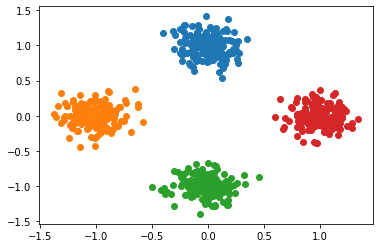


> For variance 0.15 and 10 neighbours for k-nn graph : ARI = 1.0.



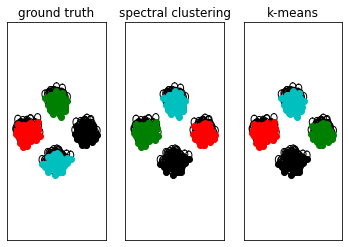

In [32]:
#@title Answer 2.3 : Spectral clustering 1
# Generate data
num_samples, n_blobs, blob_var = 600, 4, 0.15
X, Y = blobs(num_samples, n_blobs, blob_var)
print('> Generated data with blob variance 0.15 :\n')
plot_clusters(X, Y)
plt.show()

num_classes, k = 4, 10
W = build_similarity_graph(X, k=k)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, method='classic')

# Plot results, comparing to KMeans
ari = adjusted_rand_score(Y, Y_rec)
print(f'\n> For variance {blob_var} and {k} neighbours for k-nn graph : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

> Generated data with blob variance 0.20 :



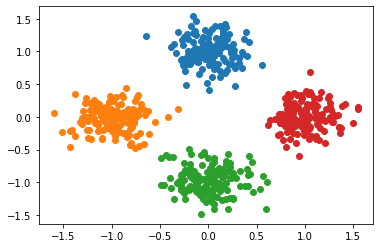


> For variance 0.2 and 75 neighbours for k-nn graph : ARI = 0.9955481068859018.



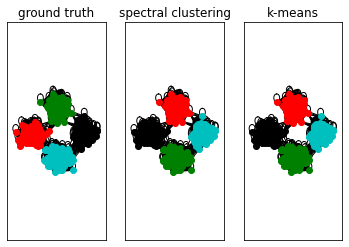

In [35]:
#@title Answer 2.3 : Spectral clustering 2
# Generate data
num_samples, n_blobs, blob_var = 600, 4, 0.2
X, Y = blobs(num_samples, n_blobs, blob_var)
print('> Generated data with blob variance 0.20 :\n')
plot_clusters(X, Y)
plt.show()

num_classes, k = 4, 75
W = build_similarity_graph(X, k=k)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, method='classic')

# Plot results, comparing to KMeans
ari = adjusted_rand_score(Y, Y_rec)
print(f'\n> For variance {blob_var} and {k} neighbours for k-nn graph : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

> Generated data with blob variance 0.3 :



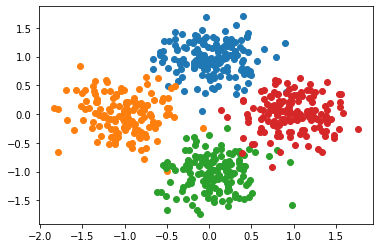


> For variance 0.3 and 5 neighbours for k-nn graph : ARI = 0.9343361831926222.



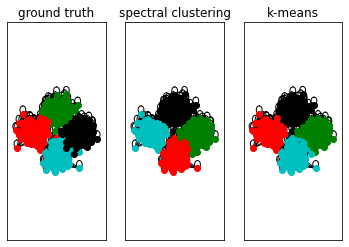

In [ ]:
#@title Answer 2.3 : Spectral clustering 3
# Generate data
num_samples, n_blobs, blob_var = 600, 4, 0.3
X, Y = blobs(num_samples, n_blobs, blob_var)
print('> Generated data with blob variance 0.3 :\n')
plot_clusters(X, Y)
plt.show()

num_classes, k = 4, 5 # reduce number of neighbours
W = build_similarity_graph(X, k=k)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, method='gap_max2')

# Plot results, comparing to KMeans
ari = adjusted_rand_score(Y, Y_rec)
print(f'\n> For variance {blob_var} and {k} neighbours for k-nn graph : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

> Generated data with blob variance 0.50 :



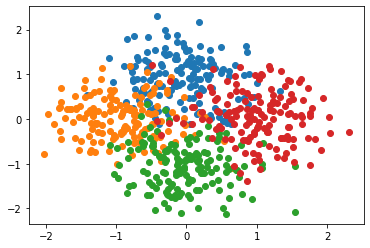


> For variance 0.5 and 6 neighbours for k-nn graph : ARI = 0.3012289594102202.



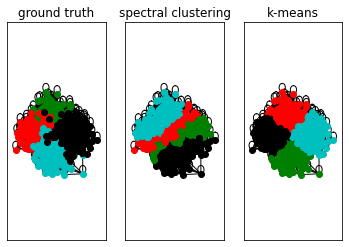

In [ ]:
#@title Answer 2.3 : Spectral clustering 4
# Generate data
num_samples, n_blobs, blob_var = 600, 4, 0.5
X, Y = blobs(num_samples, n_blobs, blob_var)
print('> Generated data with blob variance 0.50 :\n')
plot_clusters(X, Y)
plt.show()

num_classes, k = 4, 6 # reduce number of neighbours
W = build_similarity_graph(X, k=k)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, method='gap_max2')

# Plot results, comparing to KMeans
ari = adjusted_rand_score(Y, Y_rec)
print(f'\n> For variance {blob_var} and {k} neighbours for k-nn graph : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

### Question 2.4

When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

**Answer 2.4:**

Both methods were tested.

- The advantage of **thresholding** is that the eigenvectors can be explored manually and the execution times are faster than k-means. However, this method only seems to be effective when the variances of the blobs are low, in other words, when the data are more easily separable.

- An advantage of using **k-means** is the automation of the clustering task. Even if the computation times are longer than thresholding which is almost instantaneous, this method is able to generalize better on more complex data. It would therefore be the chosen method.

### Question 2.5

Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

**Answer 2.5 :**

> The results obtained with **spectral clustering** are very satisfactory. One must be careful to choose the right values for each parameter (Laplacian Matrix, way to compute similarity graph, value for epsilon/k) in order to get these results. 

> Concerning **K-Means**, the method presents much less good performances. They seem to separate the data in 2, as if a hyperplane separated the clusters. The first step of K-means consists in defining 2 centroids and then associating each point to the closest centroid. The centroids are updated at each iteration until the centroids are no longer modified. Here content of the data form, we can imagine that the 2 centroids inside the 2 moons, with one centroid off center to the left, and the other to the right. Thus at the time of labeling the data as the moons are nested one in the other, a part of the data will be associated with the wrong cluster because it is at a distance closer to the centroid associated with the other class, than its true class.

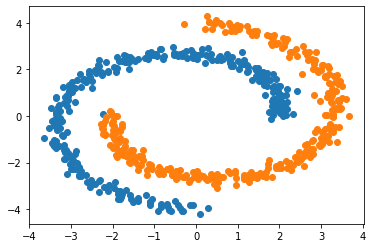

In [ ]:
#@title Answer 2.5 : Generate data
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

epsilon-nn graph (0.8) : ARI = 0.99333331487675.



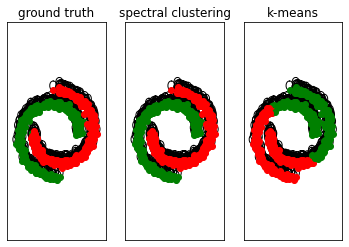

In [ ]:
#@title Answer 2.5 : Clustering
k, num_classes, eps, laplacian_normalization = 0, 2, 0.8, 'rw'

# build laplacian
W = build_similarity_graph(X, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization)

# spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes)

ari = adjusted_rand_score(Y, Y_rec)
print(f'> epsilon-nn graph ({eps}) : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Question 2.6

Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

#### **Answer 2.6 :**

> <u>Strategy :</u> First we generate data from `point_and_circle`, then for different values of epsilon, we build the similarity graph (with epsilon-graph) and perform a spectral clustering using the normal Laplacian and the random-walk regularized Laplacian.

> <u>Observations :</u> When epsilon is important (higher than 0.25), we see that the spectral clustering using the normal Laplacian and the random-walk regularized Laplacian both present perfect clusters. However when epsilon decreases (for example below than 0.23), we see that the clusters obtained are much more satisfactory with the random-walk regularized Laplacian than with the normal Laplacian.

Recall that : RatioCut(A, B) = cut(A, B)$(\frac{1}{|A|}+\frac{1}{|B|})$ and NCut(A, B) = cut(A, B)$(\frac{1}{vol(A)}+\frac{1}{vol(B)})$

  With the normal Laplacian, the optimization problem corresponds to the RatioCut problem, a problem in which we maximize the number of vertices in the clusters: which does not depend directly on the weight of the edges. With the random-walk regularized Laplacian, the optimization problem corresponds to the NCut problem, problem in which we maximize the volume of the clusters : which depends directly on the weights of the edges. 

   Thus even if these 2 methods minimize the similarity between clusters. A key to have good clusters is to maximize the similarity within each cluster obtained. However, this similarity within each cluster does not depend on the number of vertices per cluster, but rather on the edge weights which, in a way, measure this similarity. Thus, the random-walk regularized Laplacian seems to be more suitable and robust for this task.


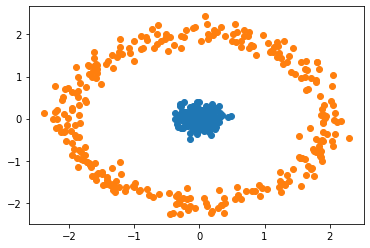

In [ ]:
#@title Answer 2.6 : Generate data
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

epsilon-nn graph (0.8) : ARI = 1.0.



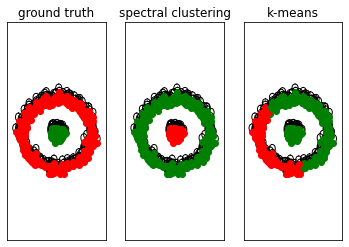

In [ ]:
#@title Answer 2.6 : Spectral clustering with normal Laplacian
k, num_classes, eps, laplacian_normalization = 0, 2, 0.8, 'unn'

# build laplacian
W = build_similarity_graph(X, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization)

# spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes)

ari = adjusted_rand_score(Y, Y_rec)
print(f'epsilon-nn graph ({eps}) : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

epsilon-nn graph (0.8) : ARI = 1.0.



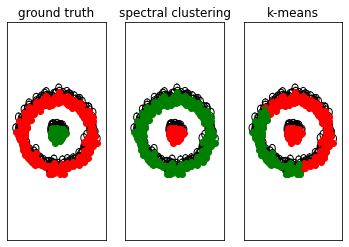

In [ ]:
#@title Answer 2.6 : Spectral clustering with random-walk regularized Laplacian
k, num_classes, eps, laplacian_normalization = 0, 2, 0.8, 'rw'

# build laplacian
W = build_similarity_graph(X, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization)

# spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes)

ari = adjusted_rand_score(Y, Y_rec)
print(f'epsilon-nn graph ({eps}) : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

epsilon-nn graph (0.23) : ARI = 0.20458003744542674.



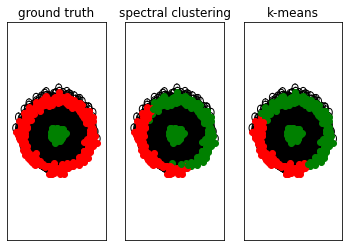

In [ ]:
#@title Answer 2.6 : Spectral clustering with normal Laplacian
k, num_classes, eps, laplacian_normalization = 0, 2, 0.23, 'unn' # 0.25 often good for eps

# build laplacian
W = build_similarity_graph(X, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization)

# spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes)

ari = adjusted_rand_score(Y, Y_rec)
print(f'epsilon-nn graph ({eps}) : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

epsilon-nn graph (0.23) : ARI = 0.9866888898781947.



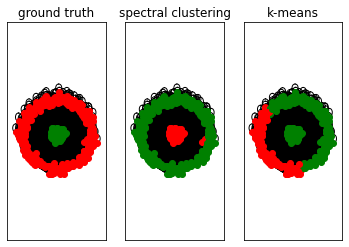

In [ ]:
#@title Answer 2.6 : Spectral clustering with random-walk regularized Laplacian
k, num_classes, eps, laplacian_normalization = 0, 2, 0.23, 'rw' # 0.25 often good for eps

# build laplacian
W = build_similarity_graph(X, eps=eps, k=k)
L = build_laplacian(W, laplacian_normalization)

# spectral clustering
Y_rec = spectral_clustering(L, num_classes=num_classes)

ari = adjusted_rand_score(Y, Y_rec)
print(f'epsilon-nn graph ({eps}) : ARI = {ari}.\n')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Question 2.7

Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

**Answer 2.7 :**

The objective is to know how the function of the cluster qualities varies according to the values of the $\epsilon$ or k parameters. The quality of the clusters is measured from the ARI metric. ARI is an indicator between 0 and 1: 0 corresponds to bad clusters, 1 corresponds to perfect clusters. We vary the values of $\epsilon$ from 0 to 1. We vary the values of $k$ from 1 to 50. 

We notice that the stability of the spectral clustering depends, indeed, on the value taken for $\epsilon$ or $k$. Here in the case of a two moons data generation : 
- the optimal values for $\epsilon$ are between $0.7$ and $0.9$. 
- the optimal values for $k$ are between $7$ and $20$. 

The procedure has been tested with the normal Laplacian, normalized Laplacian and random-walk regularized Laplacian : the results are the same.

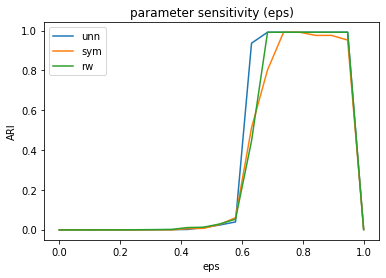

In [ ]:
#@title Answer 2.7 - Epsilon
parameter_sensitivity('eps')

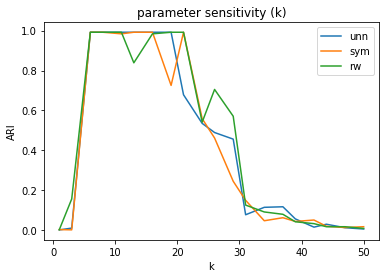

In [ ]:
#@title Answer 2.7 - k
parameter_sensitivity('k')

### Question 2.8

If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

**Answer 2.8 :**

In the case where we do not have access to the "true labels", it is no longer possible to use classical metrics of classification problem computed from the confusion matrix. Intuitively, we are looking for a metric able to evaluate the intra-cluster and inter-cluster similarities, as we have the weights of the edges available.

- For example **silhouette score** is a metric often used to evaluate the quality of a clustering without true labels. The score of a point is based on the average distance of the point to its cluster. Defined by (inspired from https://fr.wikipedia.org/wiki/Silhouette_(clustering)) :

<h4><center>$silhouette(i) = \frac{b(i)-a(i)}{max(a(i), b(i))}$ where $a(i) = \frac{1}{|C(i)|} \sum_{j \in C(i), j \neq i} d(x_i, x_j)$ and $b(i) = \max_{C \neq C(i)} \sum_{j \in C} d(x_i, x_j)$.</center></h4>

- Here in our particular case where we work with a matrix W, we can use the **modularity** defined as *a measure of the quality of a particular division of a network* (inspired from https://arxiv.org/abs/cond-mat/0308217). An advantage is that it deals both with similarity inter and intra cluster. A draawback is that it can be difficult to detect clusters with few samples. In our case, here's the formula for a network (V, E) :

$$modularity = \frac{1}{2|v|}\sum_{i, j \in V} (W_{i, j} - \frac{\sum_{j \in V} W_{i, j} \sum_{i \in V} W_{j, i}}{2v} )\mathbb{1}_{C(i)=C(j)}$$

where $C(i)$ is cluster of the sample $i$, V for Vertices and E for Edges.

### Question 3.1

Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

> Four elements - Image segmentation - Case where it works : 



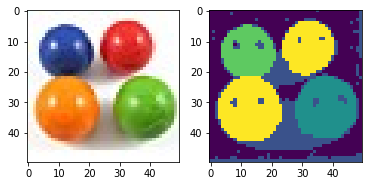

In [ ]:
#@title Answer 3.1 : Four elements - Works
print('> Four elements - Image segmentation - Case where it works : \n')
num_classes, k, eps, laplacian_normalization, chosen_eig_indices = 5, 15, 0.0, 'rw', [1, 2, 3, 4]
image_segmentation(input_img='four_elements.bmp', num_classes=num_classes, k=k, eps=eps, laplacian_normalization=laplacian_normalization, chosen_eig_indices=chosen_eig_indices)

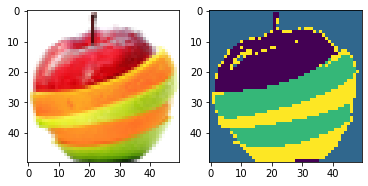

In [ ]:
#@title Answer 3.1 : Fruit salad - Works
print('> Fruit Salad - Image segmentation - Case where it works : \n')
num_classes, k, eps, laplacian_normalization, chosen_eig_indices = 4, 90, 0.0, 'rw', [1, 2]
image_segmentation(input_img='fruit_salad.bmp', num_classes=num_classes, k=k, eps=eps, laplacian_normalization=laplacian_normalization, chosen_eig_indices=chosen_eig_indices)

> Fruit Salad - Image segmentation - Case where it does not work well : 



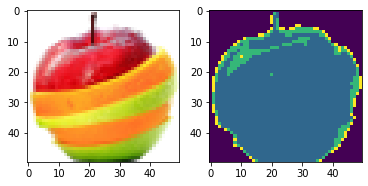

In [16]:
#@title Answer 3.1 : Fruit salad - Does not work
print('> Fruit Salad - Image segmentation - Case where it does not work well : \n')
num_classes, k, eps, laplacian_normalization, chosen_eig_indices = 4, 10, 0.0, 'unn', [1]
image_segmentation(input_img='fruit_salad.bmp', num_classes=num_classes, k=k, eps=eps, laplacian_normalization=laplacian_normalization, chosen_eig_indices=chosen_eig_indices)

### Question 3.2

A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

#### **Answer 3.2**

- Réduire l'échelle de l'image afin de réaliser la segmentation. Eventuellement reconsruire l'image par interpolation.

- Regrouper certains pixels très similaires qui apportent la même information : pixels à proximités, même intensités, même couleur en un même noeud.

> <u>First proposed technique :</u> In order to reduce the computation time of Spectral Clustering, we want to reduce the number of nodes in the graph. A first idea could be to **group very similar pixels in the same node**. For example, if pixels are locally close, have the same color and intensity: then identify them at the same node of the graph. Because in some way they "bring the same information".


> <u>Second proposed technique :</u> Still with the idea of reducing the number of nodes in the graph, the simplest technique to implement would be to perform Spectral Clustering from a **reduction in the dimentionality of the image** in order to have fewer pixels and therefore fewer nodes.

### Question 3.3

Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

#### **Answer 3.3 : Strategy**

The implemented technique will be the reduction of the number of pixels of the initial image. This corresponds to a downsampling of the initial image made with the cv2 library. Then an upsampling is done to find the dimensions of the original image. To generate the images, I used OpenAI with the following instruction: "3 kiwis on white background". The images are 1024x1024.

Dimension of original image : (1024, 1024, 3)



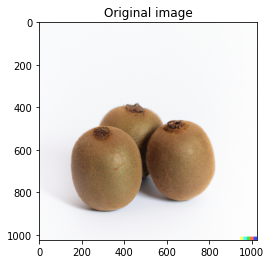


Dimension of resized image : (50, 50, 3)



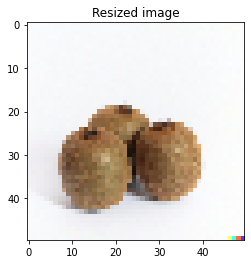


 - SPECTRAL CLUSTERING -



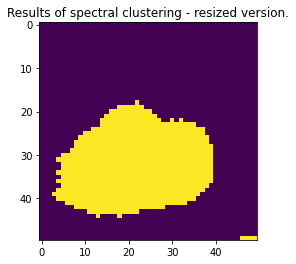

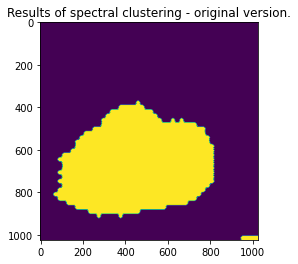


Original image with contours of clusters :



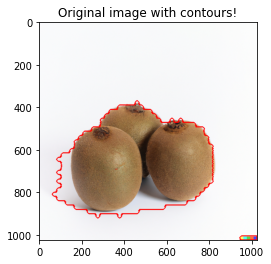


Execution time: 89.30s!


In [31]:
#@title Kiwi grouped on white

# read the image
filename = os.path.join(os.getcwd(), 'mva_graph_ml/kiwis_grouped.bmp')
image = io.imread(filename)[:,:,:3]
X_original = (image - np.min(image)) / (np.max(image) - np.min(image))
dim_original = X_original.shape[0] # 1024 per 1024
print(f'Dimension of original image : {X_original.shape}\n')
plt.imshow(X_original)
plt.title('Original image')
plt.show()

# resize the image with less pixels
X = cv2.resize(X_original, [50, 50])
dim_resized = X.shape[0] # 50 per 50
print(f'\nDimension of resized image : {X.shape}\n')
plt.imshow(X)
plt.title('Resized image')
plt.show()

print(f'\n - SPECTRAL CLUSTERING -\n')

# spectral clustering
Xr = X.reshape(dim_resized ** 2, 3)
start = time.time()
W = build_similarity_graph(Xr, var=1.0, k=15)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes=2)
end = time.time()
Y_rec = Y_rec.reshape(dim_resized, dim_resized)

# Resize segmentations image to original image dimensions
Y_rec_up = cv2.resize(Y_rec.astype(np.uint8), [dim_original, dim_original])
plt.imshow(Y_rec)
plt.title('Results of spectral clustering - resized version.')
plt.show()
plt.imshow(Y_rec_up)
plt.title('Results of spectral clustering - original version.')
plt.show()

# plot images with contours of cluster
print(f'\nOriginal image with contours of clusters :\n')
contours_cluster, _ = cv2.findContours(Y_rec_up, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
X_contours = cv2.drawContours(image.astype(np.uint8) , contours_cluster, -1, (255, 0, 0), 3)
plt.imshow(X_contours)
plt.title('Original image with contours!')
plt.show()

print(f'\nExecution time: {end-start:.2f}s!')

Dimension of original image : (1024, 1024, 3)



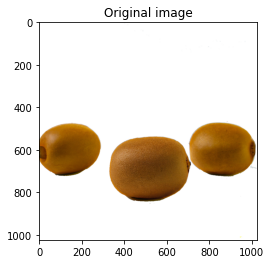


Dimension of resized image : (50, 50, 3)



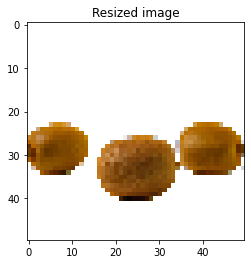


 - SPECTRAL CLUSTERING -



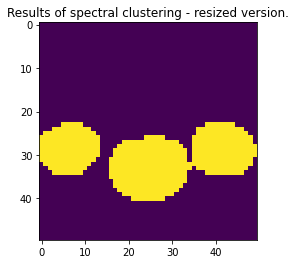

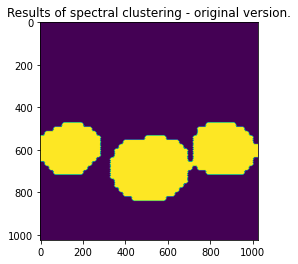


Original image with contours of clusters :



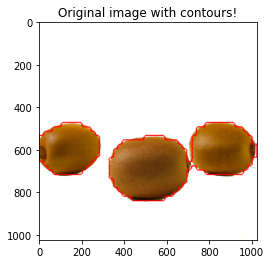


Execution time: 88.39s!


In [29]:
#@title Kiwi spaced on white

# read the image
filename = os.path.join(os.getcwd(), 'mva_graph_ml/kiwis_spaced2_bmp.bmp')
image = io.imread(filename)[:,:,:3]
X_original = (image - np.min(image)) / (np.max(image) - np.min(image))
dim_original = X_original.shape[0] # 1024 per 1024
print(f'Dimension of original image : {X_original.shape}\n')
plt.imshow(X_original)
plt.title('Original image')
plt.show()

# resize the image with less pixels
X = cv2.resize(X_original, [50, 50])
dim_resized = X.shape[0] # 50 per 50
print(f'\nDimension of resized image : {X.shape}\n')
plt.imshow(X)
plt.title('Resized image')
plt.show()

print(f'\n - SPECTRAL CLUSTERING -\n')

# spectral clustering
Xr = X.reshape(dim_resized ** 2, 3)
start = time.time()
W = build_similarity_graph(Xr, var=1.0, k=15)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes=2)
end = time.time()
Y_rec = Y_rec.reshape(dim_resized, dim_resized)

# Resize segmentations image to original image dimensions
Y_rec_up = cv2.resize(Y_rec.astype(np.uint8), [dim_original, dim_original])
plt.imshow(Y_rec)
plt.title('Results of spectral clustering - resized version.')
plt.show()
plt.imshow(Y_rec_up)
plt.title('Results of spectral clustering - original version.')
plt.show()

# plot images with contours of cluster
print(f'\nOriginal image with contours of clusters :\n')
contours_cluster, _ = cv2.findContours(Y_rec_up, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
X_contours = cv2.drawContours(image.astype(np.uint8) , contours_cluster, -1, (255, 0, 0), 3)
plt.imshow(X_contours)
plt.title('Original image with contours!')
plt.show()

print(f'\nExecution time: {end-start:.2f}s!')

Dimension of original image : (1024, 1024, 3)



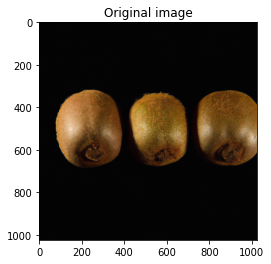


Dimension of resized image : (50, 50, 3)



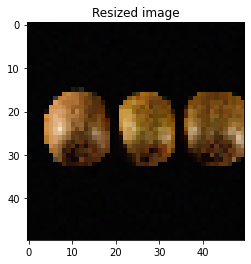


 - SPECTRAL CLUSTERING -



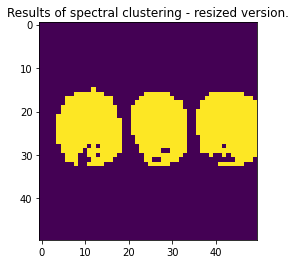

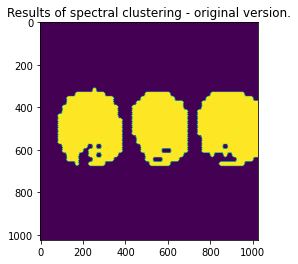


Original image with contours of clusters :



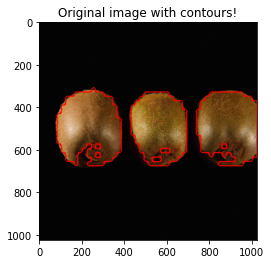


Execution time: 87.64s!


In [30]:
#@title Kiwi spaced on blac

# read the image
filename = os.path.join(os.getcwd(), 'mva_graph_ml/kiwis_spaced_fullblack_bmp2.bmp')
image = io.imread(filename)[:,:,:3]
X_original = (image - np.min(image)) / (np.max(image) - np.min(image))
dim_original = X_original.shape[0] # 1024 per 1024
print(f'Dimension of original image : {X_original.shape}\n')
plt.imshow(X_original)
plt.title('Original image')
plt.show()

# resize the image with less pixels
X = cv2.resize(X_original, [50, 50])
dim_resized = X.shape[0] # 50 per 50
print(f'\nDimension of resized image : {X.shape}\n')
plt.imshow(X)
plt.title('Resized image')
plt.show()

print(f'\n - SPECTRAL CLUSTERING -\n')

# spectral clustering
Xr = X.reshape(dim_resized ** 2, 3)
start = time.time()
W = build_similarity_graph(Xr, var=1.0, k=15)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes=2)
end = time.time()
Y_rec = Y_rec.reshape(dim_resized, dim_resized)

# Resize segmentations image to original image dimensions
Y_rec_up = cv2.resize(Y_rec.astype(np.uint8), [dim_original, dim_original])
plt.imshow(Y_rec)
plt.title('Results of spectral clustering - resized version.')
plt.show()
plt.imshow(Y_rec_up)
plt.title('Results of spectral clustering - original version.')
plt.show()

# plot images with contours of cluster
print(f'\nOriginal image with contours of clusters :\n')
contours_cluster, _ = cv2.findContours(Y_rec_up, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
X_contours = cv2.drawContours(image.astype(np.uint8) , contours_cluster, -1, (255, 0, 0), 3)
plt.imshow(X_contours)
plt.title('Original image with contours!')
plt.show()

print(f'\nExecution time: {end-start:.2f}s!')

End, thank you for reading!